In [1]:
%load_ext autoreload
%autoreload 2

#expr_path = '/home/sbanerjee/Documents/work/sparse-regression/gradvi-experiments/dsc/functions'
expr_path = '/home/saikat/Documents/work/sparse-regression/mr-ash-penalized/gradvi-experiments/dsc/functions'

import numpy as np
import sys
sys.path.append(expr_path)
import simulate

import matplotlib
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [90]:
rholist = [0.9, 0.9]
ntrain  = 500
ntest   = 500
npred   = 2000
pcausal = 10
min_block_size = 100
pve = 0.6
signal = "normal"
bfix = None

xtrain, ytrain, xtest, ytest, btrue, strue = \
    simulate.linear_model(
        ntrain, npred, pcausal, pve, ntest = ntest,
        corr_method = 'blockdiag', rho = rholist, min_block_size = min_block_size,
        signal = signal, bfix = bfix, #signal_params = {'loc': 10},
        seed = None)

In [91]:
import rpy2.robjects as robj
import rpy2.robjects.vectors as rvec
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()

def array_reduce(x):
    ndim = x.ndim
    if ndim == 1:
        res = x[0] if x.shape[0] == 1 else x
    elif ndim == 2:
        res = x.reshape(-1) if x.shape[1] == 1 else x
    return res


def robj2dict_recursive(obj):
    res = dict()
    for key in obj.names:
        elem = obj.rx2(key)
        if isinstance(elem, (rvec.FloatVector, rvec.IntVector)):
            res[key] = array_reduce(np.array(elem))
        elif isinstance(elem, rvec.StrVector):
            print (f"ERROR: Abnormal StrVector output")
        elif isinstance(elem, np.ndarray):
            res[key] = array_reduce(elem)
        elif isinstance(elem, rvec.ListVector):
            res[key] = robj2dict_recursive(elem)
    return res

def susie_r2py_wrapper(X, y, L = 20, tol = 0.001,
                       scaled_prior_variance = 0.2,
                       estimate_prior_variance = False):
    susieR = importr('susieR')
    
    n, p     = X.shape
    r_X      = robj.r.matrix(X, nrow = n, ncol = p)
    r_y      = rvec.FloatVector(y)
    
    r_fit    = susieR.susie(r_X, r_y, 
                L = L, max_iter = 2000, tol = tol,
                scaled_prior_variance = scaled_prior_variance,
                estimate_prior_variance = estimate_prior_variance)
    coef     = robj.r.coef(r_fit)
    # coef = np.sum(res['alpha'] * res['mu'], axis = 0) / res['X_column_scale_factors']

    fit_dict = robj2dict_recursive(r_fit)
    fit_dict['coef'] = coef[1:]
    return fit_dict

susie = susie_r2py_wrapper(xtrain, ytrain, L = 10, estimate_prior_variance = True)

R[write to console]: For an X with many columns, please consider installing  the Rfast package for more efficient credible set (CS)  calculations.



In [92]:
susie.keys()

dict_keys(['alpha', 'mu', 'mu2', 'Xr', 'KL', 'lbf', 'lbf_variable', 'sigma2', 'V', 'pi', 'null_index', 'elbo', 'niter', 'intercept', 'fitted', 'sets', 'pip', 'X_column_scale_factors', 'coef'])

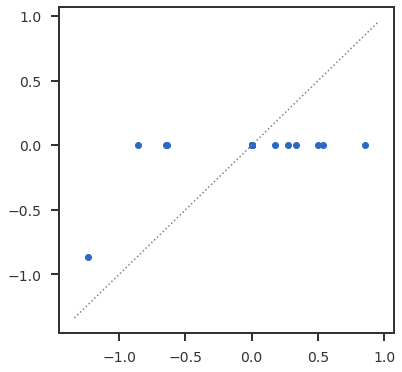

In [93]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(btrue, susie['coef'])
mpl_utils.plot_diag(ax1)
plt.show()

In [135]:
'''
GradVI
'''

from gradvi.inference import LinearRegression
from gradvi.priors import Ash

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk = np.abs((np.power(scale, np.arange(k) / k) - 1))
    return w, sk

winit, sk = initialize_ash_prior(20, scale = 2)
prior = Ash(sk, wk = winit, scaled = True)
gv1 = LinearRegression()
gv1.fit(xtrain, ytrain, prior, s2_init = 1.0)

In [158]:
from gradvi.models import LinearModel
gv1nm = LinearModel(
    gv1._X, gv1._y, gv1.theta, gv1.residual_var, gv1.prior,
    dj = gv1._dj, objtype = 'reparametrize', debug = True).get_normal_means_model()
phi, _, _ =  gv1nm.posterior()
gv1_mrash_pip = 1 - phi [:, 0]

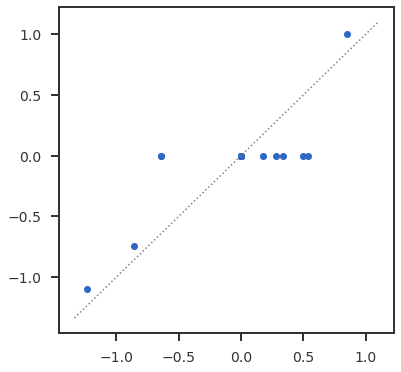

In [136]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(btrue, gv1.coef)
mpl_utils.plot_diag(ax1)
plt.show()

In [155]:
btrue_binary = np.zeros_like(btrue)
btrue_binary[btrue != 0] = 1
np.sum(btrue_binary)

10.0

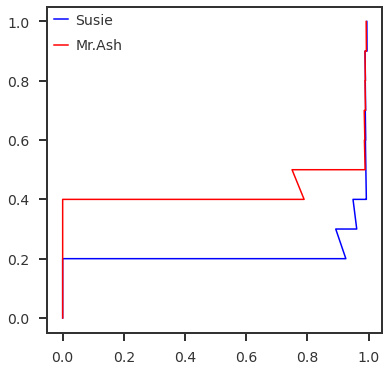

In [159]:
from sklearn import metrics as sk_metrics

def plot_fdr_recall(ax, btrue, bpred, label, color):
    precision, recall, thresholds = sk_metrics.precision_recall_curve(btrue, bpred)
    ax.plot(1 - precision, recall, label = label, color = color)
    return

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
plot_fdr_recall(ax1, btrue_binary, susie['pip'], 'Susie', 'blue')
plot_fdr_recall(ax1, btrue_binary, gv1_mrash_pip, 'Mr.Ash', 'red')
#mpl_utils.plot_diag(ax1)
ax1.legend()
plt.show()

In [143]:
gv1.theta

array([0.03384939, 0.01542241, 0.01176616, ..., 0.06975758, 0.0764715 ,
       0.06577323])

In [146]:
gv1.residual_var

0.8605773340597782

In [144]:
gv1nm.__dict__

{'_is_debug': False,
 '_loglevel': None,
 'logger':                                           gradvi:<Logger gradvi (WARNING)>
                        gradvi.optimize.root_find:<Logger gradvi.optimize.root_find (WARNING)>
               gradvi.inference.linear_regression:<Logger gradvi.inference.linear_regression (WARNING)>
                       gradvi.models.linear_model:<Logger gradvi.models.linear_model (DEBUG)>
                       gradvi.normal_means.nm_ash:<Logger gradvi.normal_means.nm_ash (WARNING)>
  gradvi.normal_means.normal_means_from_posterior:<Logger gradvi.normal_means.normal_means_from_posterior (WARNING)>,
 '_y': array([0.03384939, 0.01542241, 0.01176616, ..., 0.06975758, 0.0764715 ,
        0.06577323]),
 '_wk': array([9.98292762e-01, 8.27132498e-10, 9.77758565e-10, 1.45063178e-09,
        2.10067430e-09, 2.75069126e-09, 3.41312028e-09, 4.31073542e-09,
        5.86099681e-09, 8.87865956e-09, 1.51338977e-08, 2.85443854e-08,
        5.76623530e-08, 1.21434919e-07, 2.

In [147]:
gv1nm.shrinkage_operator(jac = False)

array([3.87421916e-06, 1.35679951e-06, 1.00574228e-06, ...,
       2.34643500e-05, 3.41856907e-05, 1.89198255e-05])

In [148]:
gv1.coef

array([3.87421916e-06, 1.35679951e-06, 1.00574228e-06, ...,
       2.34643500e-05, 3.41856907e-05, 1.89198255e-05])

In [151]:
phi, _, _ =  gv1nm.posterior()

In [152]:
phi.shape

(2000, 20)

In [154]:
gv1_mrash_pip = 1 - phi[:, 0]

array([0.99988528, 0.99991182, 0.99991432, ..., 0.99966285, 0.99955192,
       0.99971168])

In [138]:
gv1nm.__dict__

{'_b': array([3.87421916e-06, 1.35679951e-06, 1.00574228e-06, ...,
        2.34643500e-05, 3.41856907e-05, 1.89198255e-05]),
 '_prior': <gradvi.priors.ash.Ash at 0x7f625ff58190>,
 '_sj2': 0.0017211546681195574,
 '_z0': array([3.87421916e-06, 1.35679951e-06, 1.00574228e-06, ...,
        2.34643500e-05, 3.41856907e-05, 1.89198255e-05]),
 '_method': 'trisection',
 '_scale': 0.8605773340597782,
 '_d': 499.9999999999997,
 '_bracket': None,
 '_is_debug': False,
 'logger':                                           gradvi:<Logger gradvi (WARNING)>
                        gradvi.optimize.root_find:<Logger gradvi.optimize.root_find (WARNING)>
               gradvi.inference.linear_regression:<Logger gradvi.inference.linear_regression (WARNING)>
                       gradvi.models.linear_model:<Logger gradvi.models.linear_model (DEBUG)>
                       gradvi.normal_means.nm_ash:<Logger gradvi.normal_means.nm_ash (WARNING)>
  gradvi.normal_means.normal_means_from_posterior:<Logger gradvi.

In [139]:
gv1.coef

array([3.87421916e-06, 1.35679951e-06, 1.00574228e-06, ...,
       2.34643500e-05, 3.41856907e-05, 1.89198255e-05])

In [141]:
gv1nm.response

array([0.03381731, 0.01553902, 0.01173818, ..., 0.06976081, 0.07646937,
       0.06576952])

array([-6.27570345e-04, -1.39378256e-03, -1.89437276e-03,  4.24677456e-04,
       -5.14489366e-04, -1.91929941e-03, -1.43114822e-03, -1.07752874e-03,
       -5.73953347e-04,  1.28281590e-04, -5.37352075e-04, -6.17583642e-04,
        2.95216549e-04, -8.40317928e-04,  1.76282832e-03, -9.68567263e-04,
       -1.17468917e-03, -1.26068727e-03, -2.24038027e-04, -1.82580435e-03,
       -1.37177035e-03,  7.47092793e-04, -1.11414414e-03, -9.71461495e-06,
       -1.02358662e-03, -4.08326233e-04, -9.67798077e-04, -1.08563273e-03,
        9.74451978e-05, -1.27203673e-03, -5.71781635e-04, -5.93846982e-04,
       -1.50419946e-03,  5.95721836e-04, -7.55396064e-04, -3.76810824e-04,
       -2.59377612e-05, -2.89341695e-03, -1.16444711e-04, -8.49412011e-04,
       -6.07765439e-04, -1.08052738e-04, -7.59776697e-04, -3.30813549e-03,
        4.02004596e-04, -2.07747908e-03,  3.72565487e-05, -4.18039728e-04,
       -1.12035796e-03,  2.25658780e-04, -1.09546120e-03, -1.65666809e-03,
        3.62484168e-05, -